In [1]:
import xml.etree.ElementTree as et
import textwrap as tw
import pandas as pd
from termcolor import colored
import re
from nltk.tokenize import word_tokenize, sent_tokenize
import json
import matplotlib.pyplot as plt
import os

In [2]:
path = 'doc/'
files = os.listdir(path)
ls_xml = []
ls_json = []

for i in files:
    if '.xml' in i:
        ls_xml.append(i)
    elif '.json' in i:
        ls_json.append(i)

print(ls_xml)
print(ls_json)

['test1.xml', 'test2.xml', 'test3.xml']
['test4.json', 'test5.json', 'test6.json']


In [3]:
def get_xml_content(ls_xml, path, df):
    
    for xml in ls_xml:
        tree = et.parse(path + xml)
        root = tree.getroot()
        ct_at =0
        
        for x in root:
            ct_as =0
            # print('xml:',xml,'ct_at:', ct_at)
            
            if x.tag == 'PubmedArticle':
                for y in root[ct_at][0][2]:
                    # print(y.tag)
                    title = ''
                    abstract = ''
                    
                    if y.tag == 'ArticleTitle':
                        title = y.text
                        # print('Title:',title)
                        df.loc[len(df)] = [xml, ct_at, title, abstract]

                    elif y.tag == 'Abstract':
                        for z in root[ct_at][0][2][ct_as].findall('AbstractText'):
                            temp = tw.fill(z.text, initial_indent = '  ')
                            temp = temp + '\n'
                            abstract += temp

                        # print(abstract)
                        df.loc[len(df)-1, 'Content'] = abstract          
                        break
                        
                    ct_as += 1
                    
            ct_at += 1
    return df

In [4]:
def get_xml_with_kw(df, df_m, kw):
    
    for i, row in df.iterrows():
        xml = row['XML']
        ID = row['ID']
        print(xml,ID)
        title = row['Title']
        content = row['Content']
        
        if kw in title or kw in content:

            found = df_m[df_m['XML'].str.contains(xml,na=False)].empty
            # print('concat:',found)
            
            if found is True:
                df_m = pd.concat([df_m, df.loc[df['XML'] == xml]], axis=0, ignore_index=True)        

        else:
            print('The keyword can\'t be found.' )
        
    return df_m

In [5]:
def get_xml_statistics(df_m, df_f, kw):
    
    xml = ''
    n_kw = n_c = n_w = n_s = 0
    colored_text = []
    
    for i, row in df_m.iterrows():
        
        if xml != row['XML'] :
            
            if i != 0:
                df_f.loc[len(df_f)] = [xml,n_kw, n_c, n_w, n_s]
                n_kw = n_c = n_w = n_s = 0
                
            xml = row['XML']

        ID = row['ID']
        print(xml,ID)
        title = row['Title']
        content = row['Content']

        n_c += len(title)
        n_w += len(word_tokenize(title))
        n_s += len(sent_tokenize(title))               

        for t in re.split(r'(;|,|:|\s|[()])\s*',title):
            
            if t == kw:
                n_kw += 1
                colored_text.append(colored(t, 'grey','on_yellow'))
                
            else:
                colored_text.append(t)
                
        title = "".join(colored_text)
        colored_text = []
        print(title)
        df_m.loc[(df_m.XML == xml) & (df_m.ID == ID),'Title'] = title
        print('n_kw:', n_kw,'n_c:', n_c,'n_w:', n_w, 'n_s:', n_s, '\n')

        n_c += len(content)
        n_w += len(word_tokenize(content))
        n_s += len(sent_tokenize(content))            

        for t in re.split(r'(;|,|:|\s|[()])\s*',content):
            
            if t == kw:
                n_kw += 1
                colored_text.append(colored(t, 'grey','on_yellow'))
                
            else:
                colored_text.append(t)
                
        content = "".join(colored_text)
        colored_text = []
        print(content)
        df_m.loc[(df_m.XML == xml) & (df_m.ID == ID),'Content'] = content
        print('n_kw:', n_kw,'n_c:', n_c,'n_w:', n_w, 'n_s:', n_s, '\n')

        if i == len(df_m)-1:
            df_f.loc[len(df_f)] = [xml,n_kw, n_c, n_w, n_s]
        
    return df_m, df_f

In [6]:
def get_json_content(ls_json, path, df_j):
    
    for j in ls_json:

        file = open(path + j, encoding = 'utf8')
        array = json.load(file)

        for item in array:
            u_name = item['username']
            time = item['tweet_time']
            text = item['tweet_text'].strip('"')            
            df_j.loc[len(df_j)] = [j, u_name, time, text]
    
    return df_j

In [7]:
def get_json_with_kw(df_j, df_jm, kw):
    
    for i, row in df_j.iterrows():
        json = row['Json']
        u_name = row['Username']
        time = row['Time']
        print(json,u_name,time)
        text = row['Text']
        
        if kw in text:

            found = df_jm[df_jm['Json'].str.contains(json,na=False)].empty
            # print('concat:',found)
            
            if found is True:
                df_jm = pd.concat([df_jm, df_j.loc[df_j['Json'] == json]], axis=0, ignore_index=True)        

        else:
            print('The keyword can\'t be found.' )
        
    return df_jm

In [8]:
def get_json_statistics(df_jm, df_jf, kw):
    
    json = ''
    n_kw = n_c = n_w = n_s = 0
    colored_text = []
    
    for i, row in df_jm.iterrows():
        
        if json != row['Json'] :
            
            if i != 0:
                df_jf.loc[len(df_jf)] = [json,n_kw, n_c, n_w, n_s]
                n_kw = n_c = n_w = n_s = 0
                
            json = row['Json']

        u_name = row['Username']
        time = row['Time']
        print(json, u_name, time)        
        text = row['Text']

        n_c += len(text)
        n_w += len(word_tokenize(text))
        n_s += len(sent_tokenize(text))

        for t in re.split(r'(;|,|:|\s|[()])\s*',text):
            
            if t == kw:
                n_kw += 1
                colored_text.append(colored(t, 'grey','on_yellow'))
                
            else:
                colored_text.append(t)
                
        text = "".join(colored_text)
        print(text)
        colored_text = []
        df_jm.loc[(df_jm.Json == json) & (df_jm.Username == u_name) & (df_jm.Time == time),'Text'] = text
        print('n_kw:', n_kw,'n_c:', n_c,'n_w:', n_w, 'n_s:', n_s, '\n')


        if i == len(df_jm)-1:
            df_jf.loc[len(df_jf)] = [json, n_kw, n_c, n_w, n_s]
        
    return df_jm, df_jf

In [12]:
columns = ["XML","ID","Title","Content"]
df = pd.DataFrame(columns = columns)
df_m = pd.DataFrame(columns = columns)

f_col = ["XML","N_KW","N_Char","N_Word","N_Sent"]
df_f = pd.DataFrame(columns = f_col)

df = get_xml_content(ls_xml, path, df)
# print('df.head(n=10):',df.head(10))

kw = input('Search docs according to: ')
kw = kw.strip()

df_m = get_xml_with_kw(df, df_m, kw)
# print('df_m.head(n=10):',df_m.head(10))

df_m, df_f = get_xml_statistics(df_m, df_f, kw)
print('The keyword is found in {} XML file(s).'.format(len(df_f)), '\n')
print('df_f.head():',df_f.head())

Search docs according to: COVID-19
test1.xml 0
test1.xml 1
test2.xml 0
test2.xml 1
test2.xml 2
test3.xml 0
test3.xml 1
test3.xml 2
test1.xml 0
Dental care management during the COVID-19 outbreak.
n_kw: 1 n_c: 52 n_w: 8 n_s: 1 

 The level of preparedness of the healthcare system plays an
important role in management of coronavirus disease 2019 (COVID-19).
This study attempted to devise a comprehensive protocol regarding
dental care during the COVID-19 outbreak.
Embase,PubMed,and Google Scholar were searched until March 2020
for relevant papers. Sixteen English papers were enrolled to answer
questions about procedures that are allowed to perform during the
COVID-19 outbreak,patients who are in priority to receive dental care
services,the conditions and necessities for patient admission,waiting room and operatory room,and personal protective equipment
(PPE)that is necessary for dental clinicians and the office staff.
Dental treatment should be limited to patients with urgent or
emergency

In [13]:
jr_col = ['Json','Username', 'Time','Text']
df_j = pd.DataFrame(columns = jr_col)
df_jm = pd.DataFrame(columns = jr_col)

jf_col = ["Json","N_KW","N_Char","N_Word","N_Sent"]
df_jf = pd.DataFrame(columns = jf_col)

df_j = get_json_content(ls_json, path, df_j)
# print(df_j.head(10))

kw = input('Search docs according to: ')
kw = kw.strip()

df_jm = get_json_with_kw(df_j, df_jm, kw)
# print(df_jm.head(10))

df_jm, df_jf = get_json_statistics(df_jm, df_jf, kw)
print('The keyword is found in {} Json file(s).'.format(len(df_jf)),'\n')
print('df_jf.head():',df_jf.head())

Search docs according to: COVID-19
test4.json nhsengland 2020-09-20 01:55:00
test4.json doctor_oxford 2020-09-19 23:45:00
The keyword can't be found.
test4.json juliahb1 2020-09-20 00:47:00
The keyword can't be found.
test4.json cnn 2020-09-20 00:34:00
The keyword can't be found.
test5.json gretathunberg 2020-09-20 01:50:00
test5.json aminumuhammad18 2020-09-20 01:47:00
test5.json honalinur 2020-09-20 01:22:00
The keyword can't be found.
test6.json official_hfe 2020-09-19 23:23:00
The keyword can't be found.
test6.json  2020-09-20 00:52:00
The keyword can't be found.
test6.json postsubman 2020-09-19 23:38:00
The keyword can't be found.
test6.json politicalmbuzi 2020-09-20 01:48:00
test6.json bulamabukarti 2020-09-20 01:26:00
The keyword can't be found.
test4.json nhsengland 2020-09-20 01:55:00
The NHS needs more COVID-19 convalescent plasma donors. ➡️ Plasma donation is safe,easy and you could save lives.
➡️ If you've had coronavirus,you can donate at your nearest donor centre.
Find ou

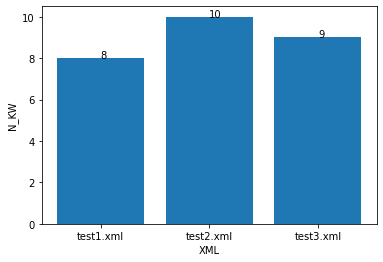

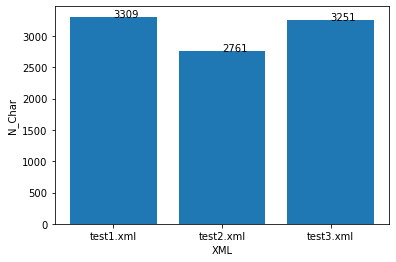

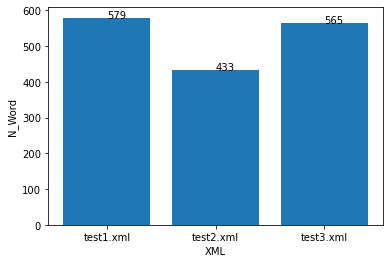

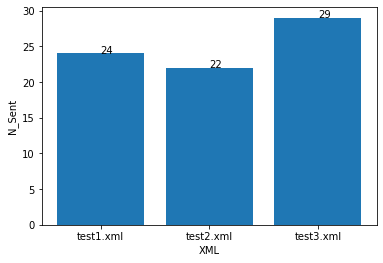

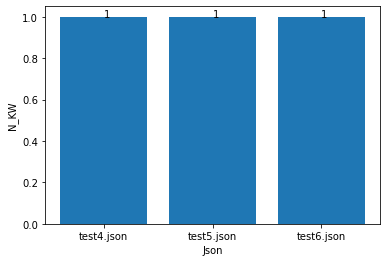

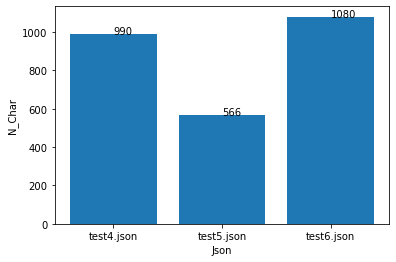

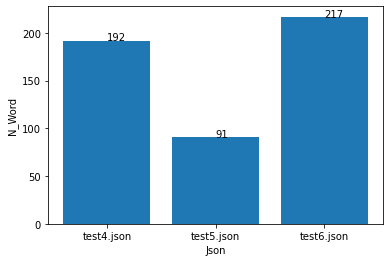

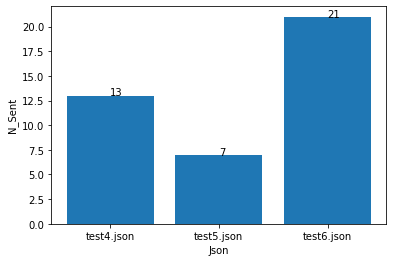

In [20]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])
        
def draw_barchart(df_f):
    col = list(df_f.columns)
    xaxis = df_f[col[0]].to_list()

    for i in range(1,len(col)):
        yaxis = df_f[col[i]].to_list()
        plt.bar(xaxis, yaxis)
        plt.xlabel(col[0])
        plt.ylabel(col[i])
        addlabels(xaxis, yaxis)
        plt.show()

draw_barchart(df_f)
draw_barchart(df_jf)